In [15]:
#!pip install -e ..
#!pip install gwpopulation

In [1]:
import jax
import jax.numpy as jnp
import gravpop
import matplotlib.pyplot as plt

import gwpopulation
gwpopulation.disable_cupy()

In [2]:
from gravpop import *
import scipy

In [53]:
TG = Gaussian1D(var_name='x', mu_name='mu', sigma_name='sigma')
mu = 0.0
sigma = 0.2
likelihood_sigma = 1.0

E, K, N = 10, 1, 1000

events = scipy.stats.norm.rvs(loc=mu, scale=sigma, size=E)
x_data = jnp.stack([scipy.stats.norm.rvs(loc=x, scale=likelihood_sigma, size=N) for x in events]).reshape(E,K,N)


event_data = {'x': x_data, # 1 events, 1 kernels, 8000 points each
              'weights': jnp.ones((E,K))/K}

HL = HybridPopulationLikelihood(sampled_models=[TG], event_data=event_data, analytic_models=[], selection_data={})



Samp = Sampler(priors = {'mu' : dist.Normal(0,3),  
                          'sigma' : dist.Uniform(0,4)}, 
                latex_symbols = {'mu' : r'$\mu$', 
                                 'sigma' : r'$\sigma$'} , 
                likelihood=HL, num_samples=8000, num_warmup=1000)

In [54]:
Samp.sample();

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9000/9000 [00:04<00:00, 1954.70it/s, 7 steps of size 3.94e-01. acc. prob=0.89]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.04      0.37     -0.04     -0.68      0.54   3566.95      1.00
     sigma      0.33      0.29      0.26      0.01      0.68   2400.45      1.00

Number of divergences: 234


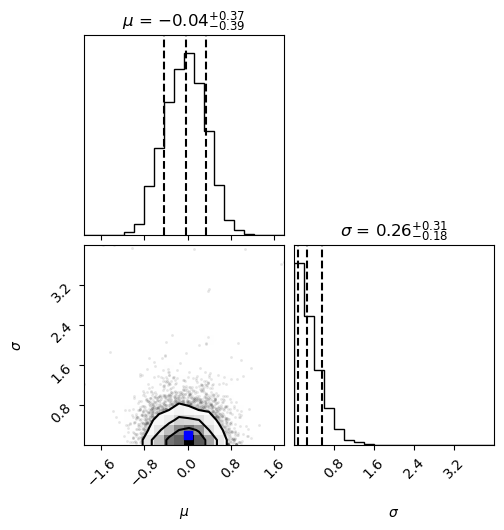

In [55]:
Samp.corner(truth=np.array([mu,sigma]));

In [52]:
Z2

Array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 1.5150477e+01, 6.9737396e+00, ..., 8.5813832e-03,
        8.3476091e-03, 8.1199501e-03],
       [0.0000000e+00, 1.5322377e+01, 7.0528641e+00, ..., 8.6787483e-03,
        8.4423227e-03, 8.2120793e-03],
       [0.0000000e+00, 1.5494450e+01, 7.1320691e+00, ..., 8.7762121e-03,
        8.5371314e-03, 8.3043035e-03]], dtype=float32)

In [14]:
M = gravpop.SmoothedTwoComponentPrimaryMassRatio()
M2 = gwpopulation.models.mass.SinglePeakSmoothedMassDistribution()

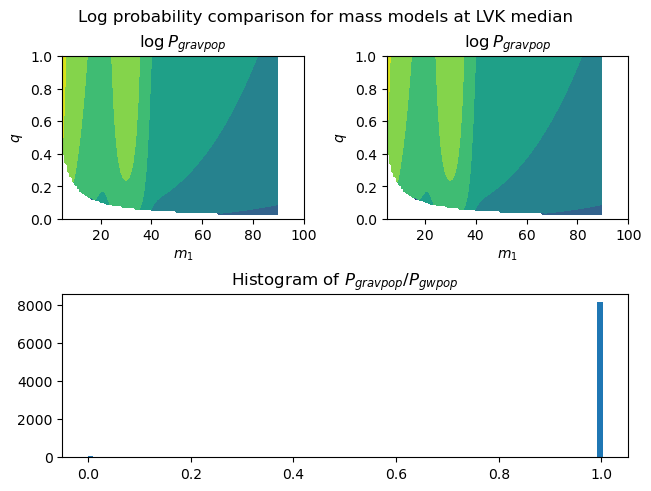

In [66]:
data = {'mass_1' : jnp.linspace(5,100,100), 'mass_ratio': jnp.linspace(0.0,1, 100)}
data['mass_1'], data['mass_ratio'] = jnp.meshgrid(data['mass_1'], data['mass_ratio'])
Lambda_0 = {'alpha':3.5, 'beta':1.1, 'delta_m':0.03, 'mpp': 30.0, 'sigpp': 3.0, 'lam':0.04, 'mmin':2.0, 'mmax': 90.0}

Z = M(data, Lambda_0)
Z2 = M2(data, **Lambda_0)

#data['mass_ratio_normal'] = (data['mass_ratio'] - 5.0/(data['mass_1']))# / (1 - 5.0/(data['mass_1']))
from matplotlib.gridspec import GridSpec
#fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,5))
fig = plt.figure(layout="constrained")
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
ax1.contourf(data['mass_1'], data['mass_ratio'], jnp.log(Z2))
ax2.contourf(data['mass_1'], data['mass_ratio'], jnp.log(Z))
ax1.set_title(r"$\log P_{gravpop}$")
ax2.set_title(r"$\log P_{gravpop}$")
ax1.set_xlabel(r"$m_1$"); ax2.set_xlabel(r"$m_1$");
ax1.set_ylabel(r"$q$"); ax2.set_ylabel(r"$q$");
ax3.hist((Z/Z2).flatten(), bins=100);
ax3.set_title(r"Histogram of $P_{gravpop} / P_{gwpop}$")
plt.suptitle("Log probability comparison for mass models at LVK median")
plt.show()

## Redshift

In [7]:
import gravpop
import gwpopulation
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
R = gravpop.PowerLawRedshift(z_max=3.0)
R2 = gwpopulation.models.redshift.PowerLawRedshift(z_max=3.0)

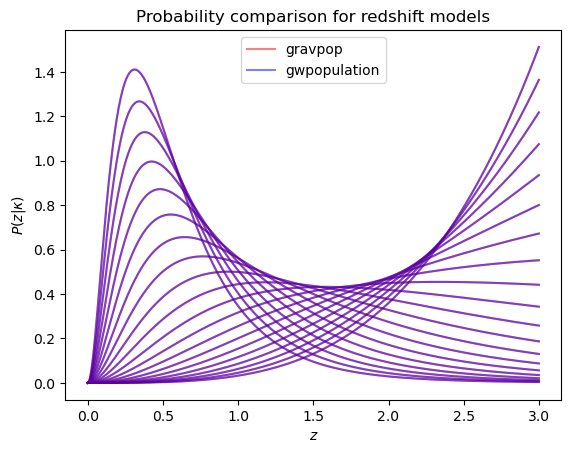

In [8]:
zs = jnp.linspace(0,3.0,1000)

lambs = np.linspace(-6,6,20)
lambs = [{'lamb' : l} for l in lambs]

R.normalization({'lamb': 0.3})

fig,ax = plt.subplots(1)
for lamb in lambs:
    dummy_1 = ax.plot(zs, np.array(R({'redshift': zs}, lamb)), color="r", alpha=0.5, label="gravpop")
    dummy_2 = ax.plot(zs, np.array(R2(pd.DataFrame({'redshift': zs}), **lamb)), color="b", alpha=0.5, label="gwpopulation")

plt.title("Probability comparison for redshift models")
ax.set_xlabel(r"$z$"); ax.set_ylabel(fr"$P(z | \kappa)$")
#ax.set_ylim(0,1)
plt.legend(handles=[dummy_1[0], dummy_2[0]])
plt.show()

In [45]:
np.round(Lambda_0["alpha"], 2)

3.5

In [13]:
SM = SmoothedTwoComponentPrimaryMassRatio(primary_mass_name="mass_1_source")

In [ ]:
SM()

In [52]:
m_1, q, mmin = Symbol('m_1'), Symbol('q'), Symbol('mmin')

In [59]:
(q - (mmin/m_1)) / (1 - (mmin/m_1))

(q - mmin/m_1)/(1 - mmin/m_1)

In [263]:
from jax import jit
@jit
def logC(mu, sigma, a , b):
    return jax.scipy.special.logsumexp(
                jnp.stack([jax.scipy.stats.norm.logcdf(b, loc=mu, scale=sigma),
                           jax.scipy.stats.norm.logcdf(a, loc=mu, scale=sigma)],
                          axis=-1),
                b=jnp.array([1,-1]),
                axis=-1
            )

@jit
def transform_gaussians(x,dx,mu,sigma):
    #x = K.x; Δx = K.Δx;
    denom = dx**2 + sigma**2
    x_ = (dx**2 * mu + sigma**2 * x)/denom;
    sigma_ = jnp.sqrt((sigma**2 * dx**2)/denom);
    return x_, sigma_

@jit
def logweight(x,dx,mu,sigma,a,b):
    x_, sigma_ = transform_gaussians(x,dx,mu,sigma);
    
    logC_ = logC(x_, sigma_, a, b); #print(logC_)
    logCmu = logC(mu ,sigma , a, b);# print(logCmu)
    logCx = logC(x ,dx , a, b); #print(logCx)
    logA = logC_ - logCmu - logCx
    return logA

@jit
def loglikelihood_kernel1d(x, dx, mu, sigma, a, b):
    logA = logweight(x,dx,mu,sigma,a,b)
    logB = jax.scipy.stats.norm.logpdf(x,loc=mu, scale=jnp.sqrt(dx**2 + sigma**2))     #normlogpdf(x,jnp.sqrt(Δx^2 + σ^2), μ)
    return logA + logB

In [578]:
#TRUNC_1D_DEFAULT_DICT = {'population' : {'mu' : }}

class TruncatedGaussian1DAnalytic:
    def __init__(self, a, b, var_name='x', mu_name='mu', sigma_name='sigma'):
        self.a = a
        self.b = b
        self.var_name = var_name
        self.mu_name = mu_name
        self.sigma_name = sigma_name
        
    def get_data(self, data, params):
        X_locations = data[self.var_name + '_mu_kernel'];
        X_scales    = data[self.var_name + '_sigma_kernel'];
        mu          = params[self.mu_name]
        sigma       = params[self.sigma_name]
        return X_locations, X_scales, mu, sigma
        
    def __call__(self, data, params):
        X_locations, X_scales, mu, sigma = self.get_data(data, params);
        loglikes = loglikelihood_kernel1d(X_locations, X_scales, mu, sigma, self.a, self.b)
        return jnp.exp(loglikes)

In [556]:
@jit
def box(x,a,b):
    return jnp.where(x > a, jnp.where(x < b, jnp.ones_like(x), jnp.zeros_like(x)), jnp.zeros_like(x))

@jit
def truncnorm(x, mu, sigma, high, low):
    norm = 2**0.5 / jnp.pi**0.5 / sigma
    norm /= jax.scipy.special.erf((high - mu) / 2**0.5 / sigma) + jax.scipy.special.erf(
        (mu - low) / 2**0.5 / sigma
    )
    prob = jnp.exp(-jnp.power(x - mu, 2) / (2 * sigma**2))
    prob *= norm*box(x, low, high)
    return prob

class TruncatedGaussian1D:
    def __init__(self, a, b, var_name='x', mu_name='mu', sigma_name='sigma'):
        self.a = a
        self.b = b
        self.var_name = var_name
        self.mu_name = mu_name
        self.sigma_name = sigma_name
        
    def get_data(self, data, params):
        Xs          = data[self.var_name];
        mu          = params[self.mu_name]
        sigma       = params[self.sigma_name]
        return Xs, mu, sigma
    
    def __call__(self, data, params):
        Xs, mu, sigma = self.get_data(data, params);
        #loglikes = jax.scipy.special.logsumexp( jnp.log(truncnorm(Xs, mu, sigma, low=a, high=b)) , axis=-1) - jnp.log(Xs.shape[-1])
        loglikes = jnp.log(truncnorm(Xs, mu, sigma, low=a, high=b).mean(axis=-1))
        return jnp.exp(loglikes)

In [560]:
## Spin Analytic Test

## Test Non Analytic Spin that it integrates to one
def test_non_analytic_spin_integrates_to_one():
    TG = TruncatedGaussian1D(a=0, b=1, var_name='x')
    params = {'mu' : 0.0, 'sigma': 0.1}
    test = lambda x: TG({'x' : x}, params)

    xs = np.linspace(0,1,10_000)
    ys = np.array([test(x) for x in xs])
    #plt.plot(xs, ys)
    print(test(0))

    assert np.isclose( np.trapz(y=ys, x=xs), 1.0, rtol=1e-3)

In [561]:
test_non_analytic_spin_integrates_to_one()

0.0


In [562]:
jax.scipy.integrate.trapezoid(truncnorm(xs, mu=0.5, sigma=0.1, low=0, high=1), xs)

Array(1., dtype=float32)

In [563]:
plt.hist(np.array(data['x']), density=True, bins=100)
xs = np.linspace(0,1,100)
plt.plot(xs, truncnorm(xs, mu=0.5, sigma=0.1, low=0, high=1))
plt.show()

KeyError: 'x'

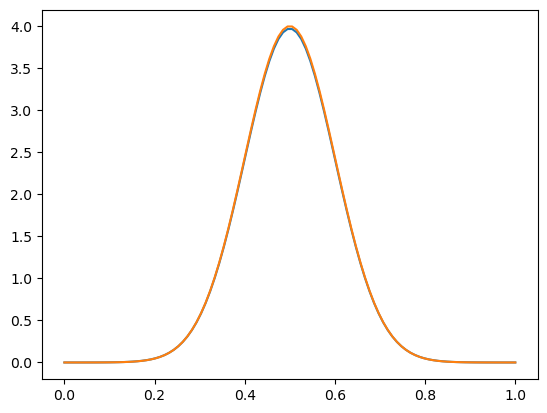

In [356]:
### Test:

data = {'x_mu_kernel' : jnp.array([0.5]), 'x_sigma_kernel' : jnp.array([0.01])}
params = {'mu' : 0.0, 'sigma': 0.01}

test = lambda mu: TGA(data, params = {'mu' : mu, 'sigma': 0.1})[0]
Y = jnp.array([test(x) for x in np.linspace(0,1,100)])

t = np.linspace(0,1,100)
plt.plot(np.linspace(0,1,100), jnp.exp(Y))
plt.plot(np.linspace(0,1,100), jnp.exp(-(((t - 0.5) / 2**0.5)**2)/(0.1**2 + 0.01**2))*4)

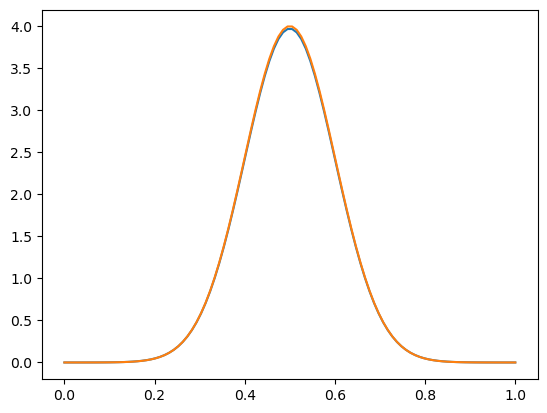

In [339]:
data = {'x_mu_kernel' : jnp.array([0,0.5]), 'x_sigma_kernel' : jnp.array([0.5,0.01])}
params = {'mu' : 0.0, 'sigma': 0.01}

test = lambda mu: TG(data, params = {'mu' : mu, 'sigma': 0.1})[-1]
Y = jnp.array([test(x) for x in np.linspace(0,1,100)])

t = np.linspace(0,1,100)
plt.plot(np.linspace(0,1,100), jnp.exp(Y))
plt.plot(np.linspace(0,1,100), jnp.exp(-(((t - 0.5) / 2**0.5)**2)/(0.1**2 + 0.01**2))*4)

In [264]:
jnp.exp(jax.scipy.stats.norm.logcdf(jnp.array([0])))

Array([0.5], dtype=float32)

In [265]:
jnp.exp(logC(jnp.array([0]), jnp.array([1]), jnp.array([0]), jnp.array([10])))

Array([0.5], dtype=float32)

In [290]:
import numpy as np
mus = jnp.array([0.0])
sigmas = jnp.array([1.0])
xs = np.random.randn(69,20)*0.1+0.5
dxs = np.random.rand(69,20)
mus_, sigmas_ = _transform(xs,dxs,mus, sigmas)

In [291]:
a = jnp.array([0.0])
b = jnp.array([1.0])
Y = loglikelihood_kernel1d(xs, dxs, mus, sigmas, a, b);

In [796]:
jax.scipy.stats.norm.logpdf()

array([[0.01611879, 0.03664567]])

In [586]:
from dataclasses import dataclass, field
from typing import List, Dict
from functools import partial

@dataclass
class HybridPopulationLikelihood:
    sampled_models:   List    # List of population models evaluated using monte-carlo
    analytic_models:  List    # List of population models evaluated analytically
    event_data:       Dict[str, jax.Array] = field(repr=False)    # Dictionary of data e.g. {'mass_1' : jnp.array([21.2, 23.0, ...], ....)}
    selection_data:   Dict[str, jax.Array] = field(repr=False)   # Dictionary of data e.g. {'mass_1' : jnp.array([21.2, 23.0, ...], ....)}
    
    def __post_init__(self):
        if not ('weights' in self.event_data):
            raise ValueError("Expected 'weights' key in the event_data dictionary")
        self.N_events = self.event_data['weights'].shape[-1]
    
    @staticmethod
    def log(x):
        return jnp.log(x + 1e-14)
    
    @staticmethod
    def aggregate_kernels(data, loglikes):
        weights = data['weights'] # E x K
        return jax.scipy.special.logsumexp( loglikes + jnp.log(weights), axis=-1) # E

    def analytic_event_bayes_factors(self, data, params):
        if len(self.analytic_models) == 0:
            return 0.0
        loglikes = sum(jnp.log(model(data, params)) for model in self.analytic_models) # E x K
        return self.aggregate_kernels(data, loglikes)
    
    def sampled_event_bayes_factors(self, data, params):
        if len(self.sampled_models) == 0:
            return 0.0
        loglikes = sum(jnp.log(model(data, params)) for model in self.sampled_models) # E x K x N
        N = loglikes.shape[-1]
        loglikes = jax.scipy.special.logsumexp( loglikes )
        return self.aggregate_kernels(data, loglikes)
    
    def logpdf(self, params):
        # Event Likelihoods
        loglikes_event = self.analytic_event_bayes_factors(self.event_data, params) \
                        + self.sampled_event_bayes_factors(self.event_data, params)
        
        # Selection Likelihood
        loglikes_selection = 0.0
        if self.selection_data:
            loglikes_selection += self.analytic_event_bayes_factors(self.selection_data, params) \
                                + self.sampled_event_bayes_factors(self.selection_data, params)
        
        return loglikes_event.sum() - self.N_events * loglikes_selection

In [787]:
from dataclasses import dataclass

from typing import List, Dict, Any, Union

import jax
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import pandas as pd

import corner

@dataclass
class Sampler:
    priors : Dict[str, dist.Distribution]
    latex_symbols : Dict[str, dist.Distribution]
    likelihood : Any = field(repr=False)
    num_samples : int = 2000
    num_warmup : int = 1000
    seed : int = 0
    target_accept_prob : float = 0.9
    summary : bool = True
    return_samples : bool = False
    
    
    def __post_init__(self):
        self.x = {}
        self._samples = None
        self.samples = None
    
    def model(self):
        for var,dist in self.priors.items():
            self.x[var] = numpyro.sample(var, dist)

        numpyro.factor('logP', self.likelihood.logpdf(self.x))
        
    def sample(self):
        # Start from this source of randomness. We will split keys for subsequent operations.
        rng_key = jax.random.PRNGKey(self.seed)
        rng_key, rng_key_ = jax.random.split(rng_key)

        # Run NUTS.
        kernel = NUTS(self.model, target_accept_prob=self.target_accept_prob)
        num_samples = self.num_samples
        mcmc = MCMC(kernel, num_warmup=self.num_warmup, num_samples=num_samples)
        mcmc.run(rng_key_)
        if self.summary:
            mcmc.print_summary()
        self._samples = mcmc.get_samples()
        
        self.samples = pd.DataFrame( self._samples)
        if self.latex_symbols:
            self.samples.rename(self.latex_symbols, inplace=True, axis=1)
        if self.return_samples:
            return self.samples
        
    def corner(self, color='k'):
        figure = corner.corner(self.samples.values,
                                labels=list(self.samples.columns),
                                quantiles=[0.16, 0.5, 0.84],
                                show_titles=True,
                                color=color,
                                title_kwargs={"fontsize": 12})
        return figure
        
    def corner_on_fig(self, fig, color='k'):
        figure = corner.corner(self.samples.values,
                                labels=list(self.samples.columns),
                                quantiles=[0.16, 0.5, 0.84],
                                show_titles=True,
                                color=color,
                                title_kwargs={"fontsize": 12}, 
                                fig=fig)
        return figure

In [788]:
@dataclass
class Asad:
    data: Dict[str, jax.Array]
    var_name : str = 'x'
    mu_name : str = 'mu'
    sigma_name : str = 'sigma'
    
    def logpdf(self, x):
        mu = x['mu']
        sigma = x['sigma']
        return jnp.sum( (-0.5 * (self.data[self.var_name] - mu)**2 / sigma**2)  - jnp.log(sigma) ) 
    
    
like = Asad({'x' : jnp.array(np.random.randn(1000))})

Samp = Sampler(
    priors = {'mu' : dist.Uniform(-3,3),  
              'sigma' : dist.Uniform(0,4)}, 
    latex_symbols = {'mu' : r'$\mu$', 
                     'sigma' : r'$\sigma$'} , 
    likelihood=like)

In [790]:
Samp.sample()

sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 3301.51it/s, 7 steps of size 8.05e-01. acc. prob=0.93]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -0.01      0.03     -0.01     -0.06      0.05   1785.89      1.00
     sigma      1.02      0.02      1.02      0.98      1.06   1093.38      1.00

Number of divergences: 0


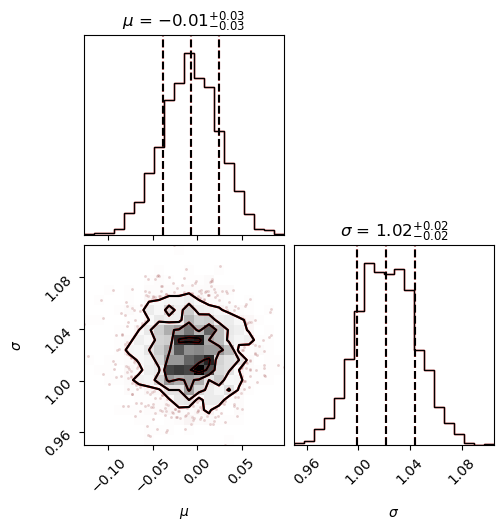

In [791]:
fig1 = Samp.corner(color='r');
Samp.corner_on_fig(fig1, color='k');

In [588]:
TGA({'x_mu_kernel':0.1, 'x_sigma_kernel':100}, {'mu': 0.1, 'sigma':0.1})

Array(1.0000176, dtype=float32)

In [632]:
import scipy
def generate_trunc_norm(mu, sigma, a, b, size=10):
    return scipy.stats.truncnorm.rvs(loc=mu, scale=sigma, a=(a-mu)/sigma, b=(b-mu)/sigma, size=size)

events = generate_trunc_norm(0.0, 0.01, 0, 1, size=100)
event_data = {'x_mu_kernel' : events[None, ...], 
              'x_sigma_kernel': 0.1*jnp.ones_like(events)[None, ...], 
              'weights':jnp.ones_like(events)[None, ...]}


TGA = TruncatedGaussian1DAnalytic(a=0, b=1)

HL = HybridPopulationLikelihood(sampled_models=[], analytic_models=[TGA], 
                                event_data=event_data, selection_data={})


mu_s = jnp.linspace(0,1,100)
sigma_s = jnp.linspace(0.001,1,100)

func = lambda mu, sigma: HL.logpdf(dict(mu=mu, sigma=sigma))

results = jnp.exp(jnp.array([[func(mu, sigma) for mu in mu_s] for sigma in sigma_s]))

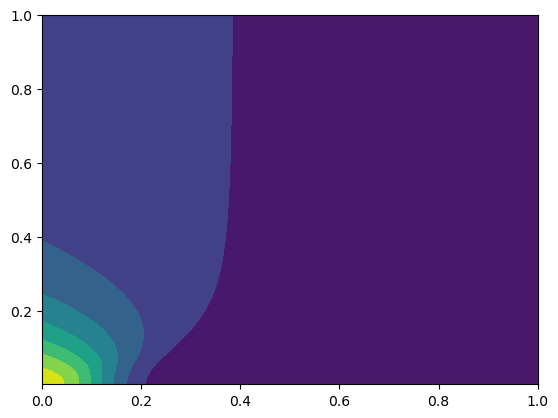

In [633]:
plt.contourf(mu_s, sigma_s, results)

In [793]:
jnp.ones((1,1,2))

Array([[[1., 1.]]], dtype=float32)

In [536]:
event_data     = {'x_mu_kernel': jnp.array([0.0]),'x_sigma_kernel': jnp.array([1.0]), 'weights': jnp.array([1])}
selection_data = {'x_mu_kernel': jnp.array([0.2]),'x_sigma_kernel': jnp.array([0.4]), 'weights': jnp.array([1])}
params = {'mu':0.1, 'sigma':0.1}

HL = HybridPopulationLikelihood(sampled_models=[], analytic_models=[TGA, TGA], 
                                    event_data=event_data, selection_data=selection_data)


jax.grad(lambda x: HL.logpdf({'mu':x[0], 'sigma':x[1]}))(jnp.array([0.0, 0.1]))

Array([-1.7176521, -3.4900768], dtype=float32)

In [585]:
HL = HybridPopulationLikelihood(sampled_models=[], analytic_models=[TGA, TGA], 
                                event_data=event_data, selection_data={})